<a href="https://colab.research.google.com/github/advoet/bgg-recs/blob/main/ml/bg_nn_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ideas:

- (***) Take the top million reviews. Use those to predict ratings for users with 10-100 reviews

- Add game info (genre, designer, etc.) to the embedding

# Board Game Recommendation Engine

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd

## Initial Setup

In [2]:
from google.colab import drive
drive.mount('/gdrive/')
!ls /gdrive

Mounted at /gdrive/
MyDrive


In [3]:
import os
BASE_PATH = '/gdrive/MyDrive/colab_files/board_game_rec/'
if not os.path.exists(BASE_PATH):
  os.makedirs(BASE_PATH)
DATA_PATH = BASE_PATH + 'data/'
if not os.path.exists(DATA_PATH):
  os.makedirs(DATA_PATH)
os.chdir(BASE_PATH)
if not os.path.exists(DATA_PATH + 'bgg-1m-top-reviewers.csv'):
  from google.colab import files
  files.upload()
  print('Don\'t forget to move the data to the data place')
  

## Load and Prep Data

In [4]:
reviews = pd.read_csv('data/bgg-1m-top-reviewers.csv', usecols=['user', 'rating', 'name', 'ID'])
reviews.rename(columns = {'name': 'game_name', 'ID': 'bgg_game_id'}, inplace=True)

First, let's assign each user and game a unique ID

In [5]:
reviews['user_id'] = reviews.groupby('user').ngroup()
game_id = { id : i for i, id in enumerate(reviews.bgg_game_id.unique()) }
reviews['game_id'] = reviews.bgg_game_id.map(game_id.get)
reviews = reviews[['user', 'game_name', 'rating', 'user_id', 'game_id', 'bgg_game_id']]
reviews.head()

,user,game_name,rating,user_id,game_id,bgg_game_id
0,Torsten,Pandemic,10.0,315,0,30549
1,avlawn,Pandemic,10.0,368,0,30549
2,cfarrell,Pandemic,10.0,405,0,30549
3,zunyer,Pandemic,10.0,800,0,30549
4,skeletodoc,Pandemic,10.0,709,0,30549


We also have secondary information about the games themselves for a content-based model

In [6]:
game_info = pd.read_csv('data/games_detailed_info.csv', index_col = 'id')

In [7]:
game_info.drop(
    columns = [
        'Unnamed: 0',
        'thumbnail',
        'image',
        'alternate',
        'suggested_language_dependence',
        'boardgameimplementation',
        'trading',
        'wanting',
        'wishing',
        'numcomments',
        'numweights',
        'boardgameintegration',
        'boardgamecompilation',
        'boardgamefamily',
        'RPG Item Rank',
        'Accessory Rank',
        'Video Game Rank',
        'Amiga Rank',
        'Commodore 64 Rank',
        'Customizable Rank',
        'Arcade Rank',
        'Atari ST Rank',
    ],
    inplace = True
)

In [8]:
print('\n'.join(game_info.columns))

type
primary
description
yearpublished
minplayers
maxplayers
suggested_num_players
suggested_playerage
playingtime
minplaytime
maxplaytime
minage
boardgamecategory
boardgamemechanic
boardgameexpansion
boardgamedesigner
boardgameartist
boardgamepublisher
usersrated
average
bayesaverage
Board Game Rank
Strategy Game Rank
Family Game Rank
stddev
median
owned
averageweight
Party Game Rank
Abstract Game Rank
Thematic Rank
War Game Rank
Children's Game Rank


### First pass (Net defined)

Basic idea: 
find someone with a similar review profile and copy their rating.

Training Ideas:
 - Take a small number of users, and repeatedly vary the masks to learn their game preferences
 - 

In [9]:
from torch.utils.data import Dataset, DataLoader
class BoardGameDataSet(Dataset):
  def __init__(self, df):
    super().__init__()
    self.reviews = df

  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, idx):
    # returns tuple (user id, game id, rating)
    if torch.is_tensor(idx):
      idx = idx.tolist()
    user, game, rating = self.reviews.iloc[idx][['user_id', 'game_id', 'rating']]
    return torch.tensor(user, dtype = torch.float32), \
            torch.tensor(game, dtype = torch.float32), \
            torch.tensor(rating, dtype = torch.float32)
    

In [10]:
review_dataset = BoardGameDataSet(reviews)

train_size = int(.8*len(review_dataset))
test_size = len(review_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(
    review_dataset, 
    [train_size, test_size],
)

### Trying to improve the training process

Smarter Dataset:

1. For each row, mask n% of entries
 - 10 - 50% ?
 - make sure to allow different masks on the same reviewer
 - Perhaps trim to most reviewed 5-10k games to reduce sparsity
2. \_\_getitem\_\_ should
 - create a mask
 - return prior_ratings, target_ratings
 - how to deal with sparsity? 
    - L1 regularization to find key games
    - Use the game rating / popularity / to measure importance
    

In [11]:
user_matrix = reviews.pivot(index = 'user_id', columns = 'game_id', values = 'rating')
user_matrix.head()

game_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,18972,18973,18974,18975,18976,18977,18978,18979,18980,18981,18982,18983,18984,18985,18986,18987,18988,18989,18990,18991,18992,18993,18994,18995,18996,18997,18998,18999,19000,19001,19002,19003,19004,19005,19006,19007,19008,19009,19010,19011
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,8.0,7.0,2.0,5.0,8.0,5.0,8.0,5.0,5.0,4.0,2.0,7.0,5.0,5.0,5.0,7.0,10.0,4.0,8.0,7.0,5.0,5.0,4.0,8.0,5.0,7.0,6.0,9.0,8.0,9.0,4.0,4.0,4.0,3.0,NaN,7.0,NaN,10.0,8.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN
1,8.0,7.0,7.0,9.0,10.0,8.0,7.0,8.0,9.0,8.0,6.0,7.0,7.0,7.0,8.0,8.0,6.0,NaN,7.0,6.0,8.0,6.0,7.0,8.0,8.0,8.0,8.0,NaN,9.0,7.0,NaN,NaN,7.0,NaN,5.0,9.0,NaN,6.0,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8.0,9.0,7.0,8.0,9.0,10.0,10.0,10.0,10.0,8.0,8.0,8.0,10.0,7.0,9.0,8.0,6.0,9.0,8.0,7.0,8.0,8.0,8.0,9.0,8.0,8.0,7.0,9.0,NaN,8.0,9.0,10.0,8.0,NaN,8.0,10.0,NaN,NaN,7.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5.0,6.0,NaN,7.0,6.0,7.0,6.0,6.0,5.0,NaN,6.0,5.0,NaN,6.0,9.0,7.0,7.0,NaN,6.0,6.0,8.0,9.0,6.0,3.0,6.0,8.0,4.0,10.0,NaN,6.0,6.0,6.0,7.0,NaN,4.0,NaN,5.0,NaN,8.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8.0,6.0,7.0,5.5,6.3,7.5,8.6,7.5,8.0,6.2,7.0,7.0,6.5,6.2,5.8,7.0,6.7,3.0,6.0,7.7,7.3,6.5,7.0,6.3,7.6,7.5,6.5,6.0,NaN,7.0,7.0,7.3,7.0,6.7,7.0,5.7,7.7,7.5,7.3,6.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
user_matrix.loc[3].index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            19002, 19003, 19004, 19005, 19006, 19007, 19008, 19009, 19010,
            19011],
           dtype='int64', name='game_id', length=19012)

In [13]:
user_id = 3
all_games_for_revieweer = user_matrix.iloc[user_id]
reviewed = all_games_for_revieweer[all_games_for_revieweer.notna()]
priors = reviewed.sample(frac = .8)
target = reviewed.drop(priors.index).sample(n=1)
target.index.item()


2334

In [14]:

from torch.utils.data import Dataset, DataLoader
class CollaborativeDataSet(Dataset):
  def __init__(self, user_matrix, seed = 42):
    super().__init__()
    self.user_matrix = user_matrix
    self.seed = seed

  def __len__(self):
    return len(self.user_matrix)
  
  def __getitem__(self, user_id):
    # returns tuple (user id, game id, rating)
    if torch.is_tensor(user_id):
      user_id = user_id.tolist()

    all_games = user_matrix.iloc[user_id]
    reviewed = all_games[all_games.notna()]
    # perhaps use kwarg 'weights' and value extreme reviews
    # use a random seed for reproducibility? but we want to train on different splits
    priors = reviewed.sample(frac = .5)
    masked_reviews = all_games.mask()
    target = reviewed.drop(priors.index).sample(n=1)
    new_game = target.index.item()
    rating = target.item()

    ## NOT QUITE RIGHT. Need to work with a full row for the embedding.
    return torch.tensor(priors, dtype = torch.float32), \
            torch.tensor(targets, dtype = torch.float32)

    '''
    user, game, rating = self.reviews.iloc[idx][['user_id', 'game_id', 'rating']]
    return torch.tensor(user, dtype = torch.float32), \
            torch.tensor(game, dtype = torch.float32), \
            torch.tensor(rating, dtype = torch.float32)
    '''

## Defining the Network

To-Do:
 - saving and loading with pt_util
 - different embeddings

In [15]:
import pt_util

ARCH_PATH = DATA_PATH + 'collaborative_neural_filtering/'
if not os.path.exists(ARCH_PATH):
    os.makedirs(ARCH_PATH)

class HybridNet(nn.Module):
  def __init__(self, n_users, n_games, n_factors = 50):
    super().__init__()
    self.n_users = n_users
    self.n_games = n_games
    self.metrics = {}
    self.user_embedding = nn.Embedding(n_users, n_factors)
    self.game_embedding = nn.Embedding(n_games, n_factors)
    self.drop = nn.Dropout(.2)
    self.fc1 = nn.Linear(2*n_factors, 128)
    self.fc2 = nn.Linear(128, 64)
    self.out = nn.Linear(64, 1)
    
  def forward(self, user, game):
    x = torch.cat([self.user_embedding(user.long()), self.game_embedding(game.long())], dim = 1)
    x = self.drop(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = 10*torch.sigmoid(self.out(x))
    return x

  def loss(self, prediction, label):
    return nn.MSELoss()(prediction, label)
  
  def save_model(self, file_path, num_to_keep = 1):
    pt_util.save(self, file_path, num_to_keep)
      
  def save_best_model(self, accuracy, file_path, num_to_keep=1):

    try:
        best_accuracy = torch.load(file_path)['metrics']['accuracy']
        if accuracy > best_accuracy:
            self.save_model(file_path, num_to_keep)
    except FileNotFoundError:
        self.save_model(file_path, num_to_keep)


  def load_model(self, file_path):
    pt_util.restore(self, file_path)
      
  def load_last_model(self, dir_path):
    return pt_util.restore_latest(self, dir_path)
    

In [16]:
import time
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    losses = []
    for batch_idx, (user, game, label) in enumerate(train_loader):
        user, game, label = user.to(device), game.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(user, game)
        loss = model.loss(output.float().view(-1), label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                time.ctime(time.time()),
                epoch, batch_idx * len(game), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            print(f'Sample Rating:\n user_id: {user[0]}, game_id: {game[0]} \n output: {output[0].item()}, label: {label[0]}')
            print('-----------------------------------------------------------')
    return np.mean(losses)

def test(model, device, test_loader, log_interval=None):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (user, game, label) in enumerate(test_loader):
            user, game, label = user.to(device), game.to(device), label.to(device)
            output = model(user, game)

            test_loss_on = model.loss(output.float().view(-1), label).item()
            test_loss += test_loss_on
            pred = output.float().view(-1)
            correct_mask = torch.isclose(pred, label, rtol = 0, atol = .5)
            num_correct = correct_mask.sum().item()
            correct += num_correct

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))
    return test_loss, test_accuracy

Model from NCF paper: https://arxiv.org/pdf/1708.05031.pdf

In [17]:
''' TODO ############################
class HybridNet(nn.Module):
  def __init__(self, n_users, n_games, n_factors = 50):
    super().__init__()
    self.n_users = n_users
    self.n_games = n_games
    
    self.user_embedding = nn.Embedding(n_users, n_factors)
    self.game_embedding = nn.Embedding(n_games, n_factors)
    self.drop = nn.Dropout(.2)
    self.fc1 = nn.Linear(2*n_factors, 128)
    self.fc2 = nn.Linear(128, 64)
    self.out = nn.Linear(64, 1)
    
  def forward(self, user, game):
    x = torch.cat([self.user_embedding(user.long()), self.game_embedding(game.long())], dim = 1)
    x = self.drop(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = 10*torch.sigmoid(self.out(x))
    return x
  '''

' TODO ############################\nclass HybridNet(nn.Module):\n  def __init__(self, n_users, n_games, n_factors = 50):\n    super().__init__()\n    self.n_users = n_users\n    self.n_games = n_games\n    \n    self.user_embedding = nn.Embedding(n_users, n_factors)\n    self.game_embedding = nn.Embedding(n_games, n_factors)\n    self.drop = nn.Dropout(.2)\n    self.fc1 = nn.Linear(2*n_factors, 128)\n    self.fc2 = nn.Linear(128, 64)\n    self.out = nn.Linear(64, 1)\n    \n  def forward(self, user, game):\n    x = torch.cat([self.user_embedding(user.long()), self.game_embedding(game.long())], dim = 1)\n    x = self.drop(x)\n    x = F.relu(self.fc1(x))\n    x = F.relu(self.fc2(x))\n    x = 10*torch.sigmoid(self.out(x))\n    return x\n  '

## Training

Using device cuda
num workers: 2
Restoring:
user_embedding.weight -> 	torch.Size([801, 8]) = 0MB
game_embedding.weight -> 	torch.Size([19012, 8]) = 0MB
fc1.weight -> 	torch.Size([128, 16]) = 0MB
fc1.bias -> 	torch.Size([128]) = 0MB
fc2.weight -> 	torch.Size([64, 128]) = 0MB
fc2.bias -> 	torch.Size([64]) = 0MB
out.weight -> 	torch.Size([1, 64]) = 0MB
out.bias -> 	torch.Size([1]) = 0MB

Restored all variables
No new variables
Restored /gdrive/MyDrive/colab_files/board_game_rec/data/collaborative_neural_filtering/checkpoints/28.pt
Wed Feb 17 07:09:39 2021 Train Epoch: 28 [0/800562 (0%)]	Loss: 1.238978
Sample Rating:
 user_id: 378.0, game_id: 49.0 
 output: 7.672614574432373, label: 8.0
-----------------------------------------------------------
Wed Feb 17 07:09:50 2021 Train Epoch: 28 [25600/800562 (3%)]	Loss: 1.293514
Sample Rating:
 user_id: 465.0, game_id: 1581.0 
 output: 7.253593444824219, label: 7.0
-----------------------------------------------------------
Wed Feb 17 07:10:02 2021

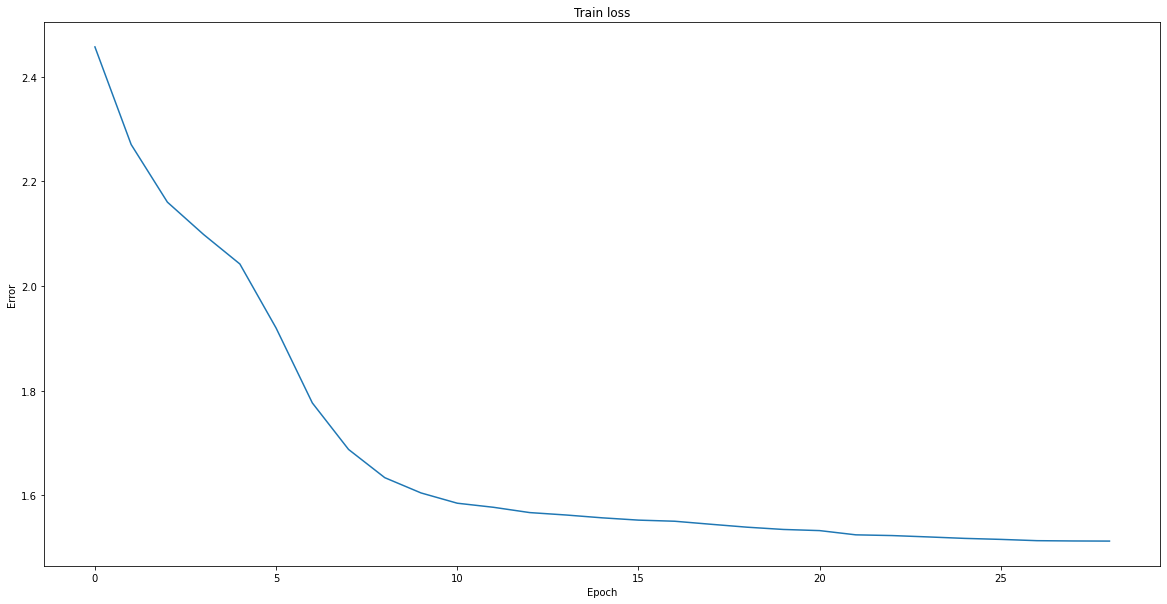

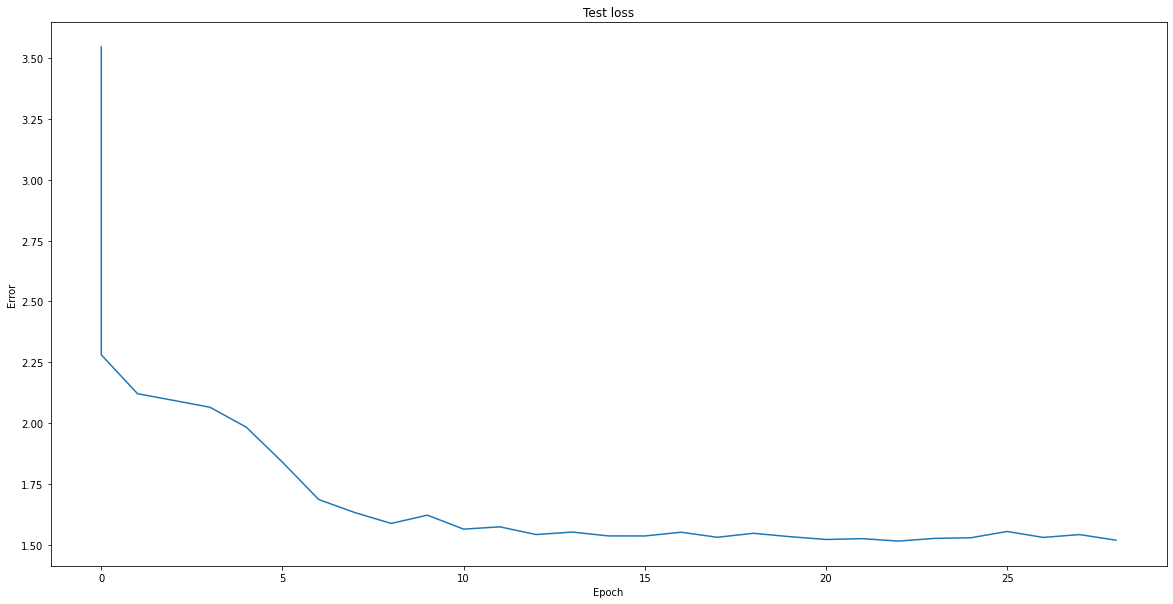

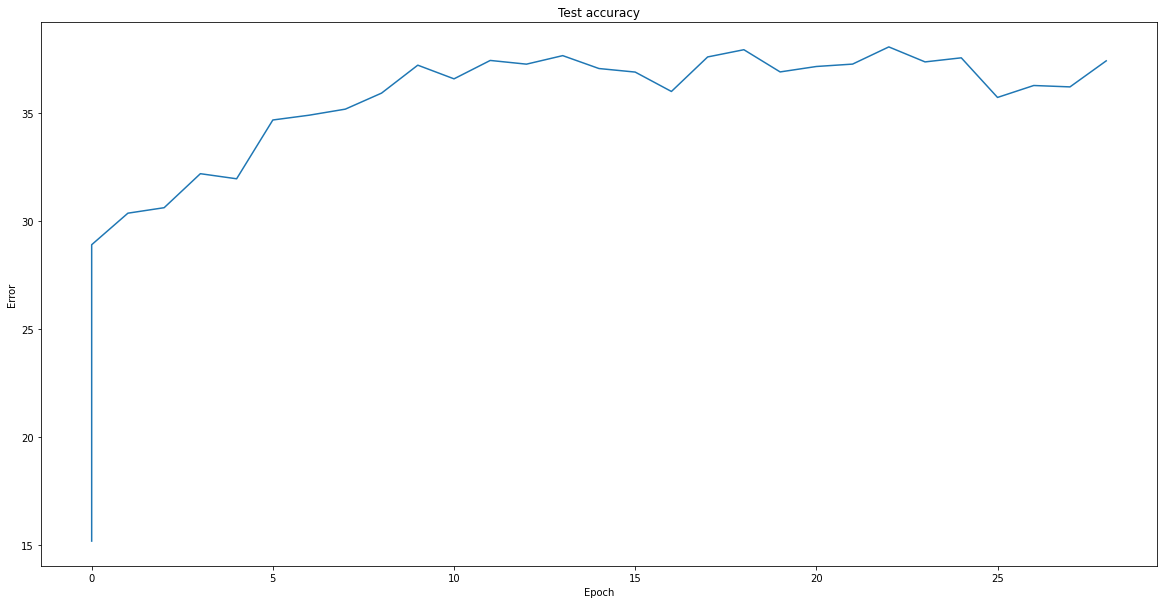

In [18]:
def main():
  # HYPERPARAMETERS
  BATCH_SIZE = 256
  FEATURE_SIZE = 8
  EPOCHS = 50
  LEARNING_RATE = .01
  MOMENTUM = 0.9
  WEIGHT_DECAY = .001
  USE_CUDA = True
  PRINT_INTERVAL = 100
  LOG_PATH = DATA_PATH + 'log.pkl'

  #UNKNOWN
  import importlib; importlib.reload(pt_util)


  # CUDA SETUP
  use_cuda = USE_CUDA and torch.cuda.is_available()
  device = torch.device('cuda' if use_cuda else 'cpu')
  print('Using device', device)
  import multiprocessing
  num_workers = multiprocessing.cpu_count()
  print('num workers:', num_workers)
  kwargs = {
    'num_workers' : num_workers,
    'pin_memory' : True
  } if use_cuda else {}

  # DATALOADERS
  train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    **kwargs,
  )
  test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    **kwargs,
  )

  # MODEL SETUP
  model = HybridNet(
    n_users = len(reviews.user.unique()),
    n_games = len(reviews.game_id.unique()),
    n_factors = FEATURE_SIZE,
  ).to(device)

  # OPTIMIZER
  optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  '''
  optimizer = optim.Adam(
      model.parameters(),
      lr = LEARNING_RATE,
      weight_decay = WEIGHT_DECAY,
  )
  '''

  # SAVE / LOAD
  start_epoch = model.load_last_model(ARCH_PATH + 'checkpoints')
  train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
  if len(test_losses) is 0:
      test_loss, test_accuracy = test(model, device, test_loader)
      test_losses.append((start_epoch, test_loss))
      test_accuracies.append((start_epoch, test_accuracy))

  # TRAINING LOOP
  try:
    for epoch in range(start_epoch, EPOCHS + 1):
      lr = LEARNING_RATE * np.power(.25, (int(epoch / 6)))
      train_loss = train(
          model,
          device,
          train_loader,
          optimizer,
          epoch,
          PRINT_INTERVAL,
      )
      test_loss, test_accuracy = test(
          model,
          device,
          test_loader,
      )
      train_losses.append((epoch, train_loss))
      test_losses.append((epoch, test_loss))
      test_accuracies.append((epoch, test_accuracy))
      model.metrics['accuracy'] = test_accuracy
      pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
      model.save_best_model(test_accuracy, ARCH_PATH + f'checkpoints/{epoch}.pt')
  except KeyboardInterrupt as ke:
    print('Interrupted')
  except:
    import traceback
    traceback.print_exc()
  finally:
    model.save_model(ARCH_PATH + f'checkpoints/{epoch}.pt', 1)
    ep, val = zip(*train_losses)
    pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
    ep, val = zip(*test_losses)
    pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
    ep, val = zip(*test_accuracies)
    pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')

main()